In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.helper import DataNormalizer
from cvaei.visualize import scatter_plot_ma2
from cvaei.examples.MA2 import MovingAverage2
from cvaei.examples.two_moons import TwoMoons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


# Initialise the Model

In [4]:
ma2 = MovingAverage2()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = ma2.prepare_data(10000)
observed_data = ma2.observed_data()
ma2.check_normalizer()


Training Theta Shape: torch.Size([10000, 2])
Training Data Shape: torch.Size([10000, 100])
Validation Theta Shape: torch.Size([10000, 2])
Validation Data Shape: torch.Size([10000, 100])
Normalization and denormalization process is consistent for both parameters and observed data.


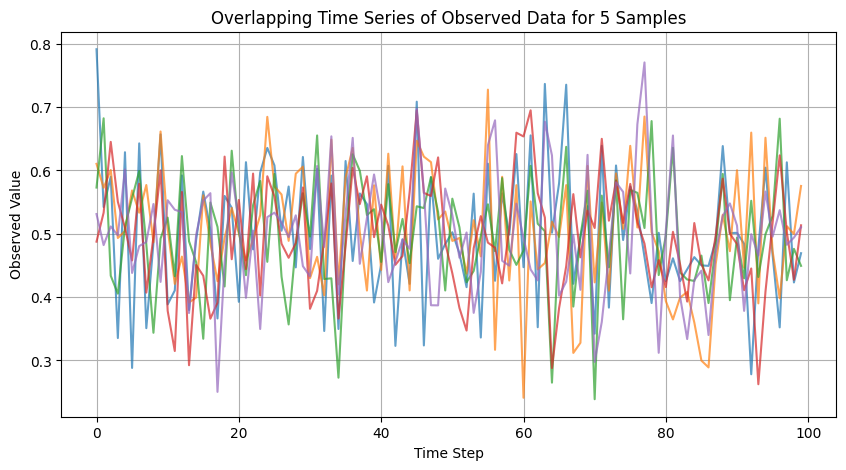

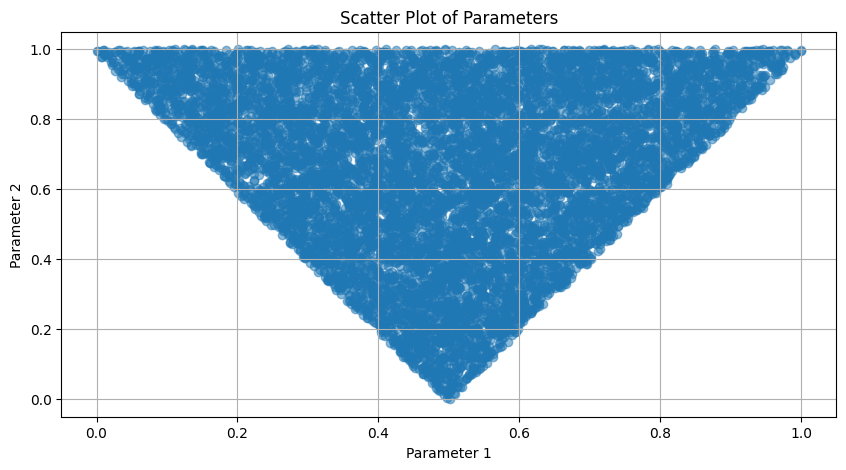

In [5]:
ma2.plot_observation(train_data_norm)
ma2.plot_prior(train_theta_norm)

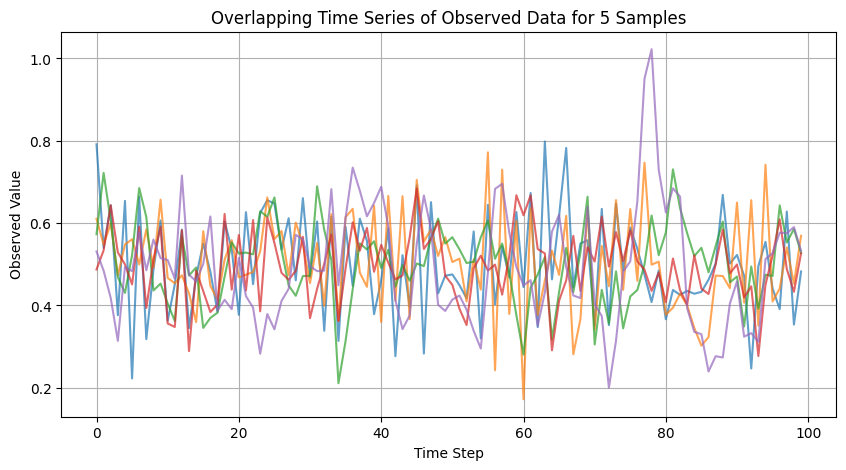

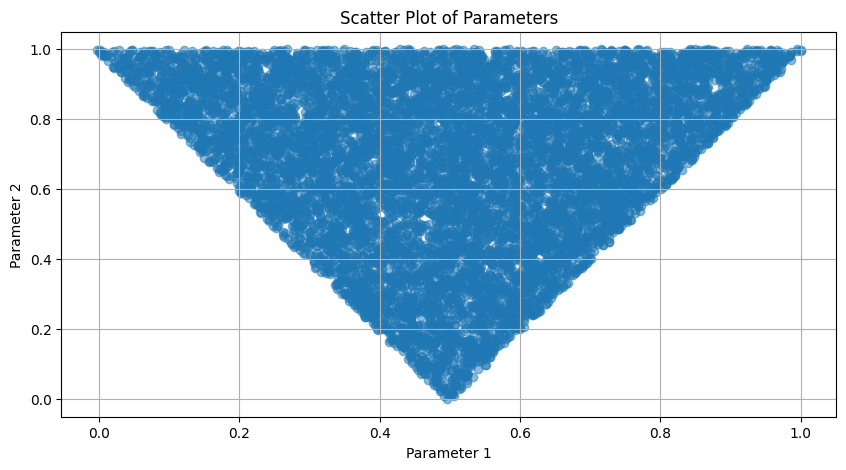

In [6]:
ma2.plot_observation(val_data_norm)
ma2.plot_prior(val_theta_norm)

# Define the CVAE Network

In [7]:
input_dim = 2
latent_dim = 10
conditional_dim = 100
encoder_hidden_dims = [200,200]
decoder_hidden_dims = [200,200]
activation_fn = nn.ReLU()

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn)


optimizer = optim.AdamW(network.parameters(), lr=1e-4)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)

print(network)

CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=200, out_features=10, bias=True)
    (fc_logvar): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=110, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU()
    )
    (final_layer): Linear(in_features=200, out_features=2, bias=True)
  )
)


In [8]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=40, 
                    device=device,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= ma2.simulator)

Using CPU for training.
Epoch 1/40: Beta: 0.0, total_loss: 4.1914, recon_loss: 0.6564, misfit_loss: 3.5350, kl_div: 0.0739
Epoch 1/40 Validation: Beta: 0.0, total_loss: 3.3594, recon_loss: 0.5598, misfit_loss: 2.7997, kl_div: 0.1022

Epoch 1: Validation loss improved to 0.0003
Epoch 2/40: Beta: 0.1, total_loss: 3.0306, recon_loss: 0.4778, misfit_loss: 2.5400, kl_div: 0.1286
Epoch 2/40 Validation: Beta: 0.1, total_loss: 2.4833, recon_loss: 0.4014, misfit_loss: 2.0655, kl_div: 0.1637

Epoch 2: Validation loss improved to 0.0002
Epoch 3/40: Beta: 0.2, total_loss: 2.3579, recon_loss: 0.3317, misfit_loss: 1.9911, kl_div: 0.1756
Epoch 3/40 Validation: Beta: 0.2, total_loss: 2.0240, recon_loss: 0.2653, misfit_loss: 1.7230, kl_div: 0.1781

Epoch 3: Validation loss improved to 0.0002
Epoch 4/40: Beta: 0.3, total_loss: 2.0389, recon_loss: 0.2114, misfit_loss: 1.7814, kl_div: 0.1537
Epoch 4/40 Validation: Beta: 0.3, total_loss: 1.8112, recon_loss: 0.1634, misfit_loss: 1.6128, kl_div: 0.1166

Epoc

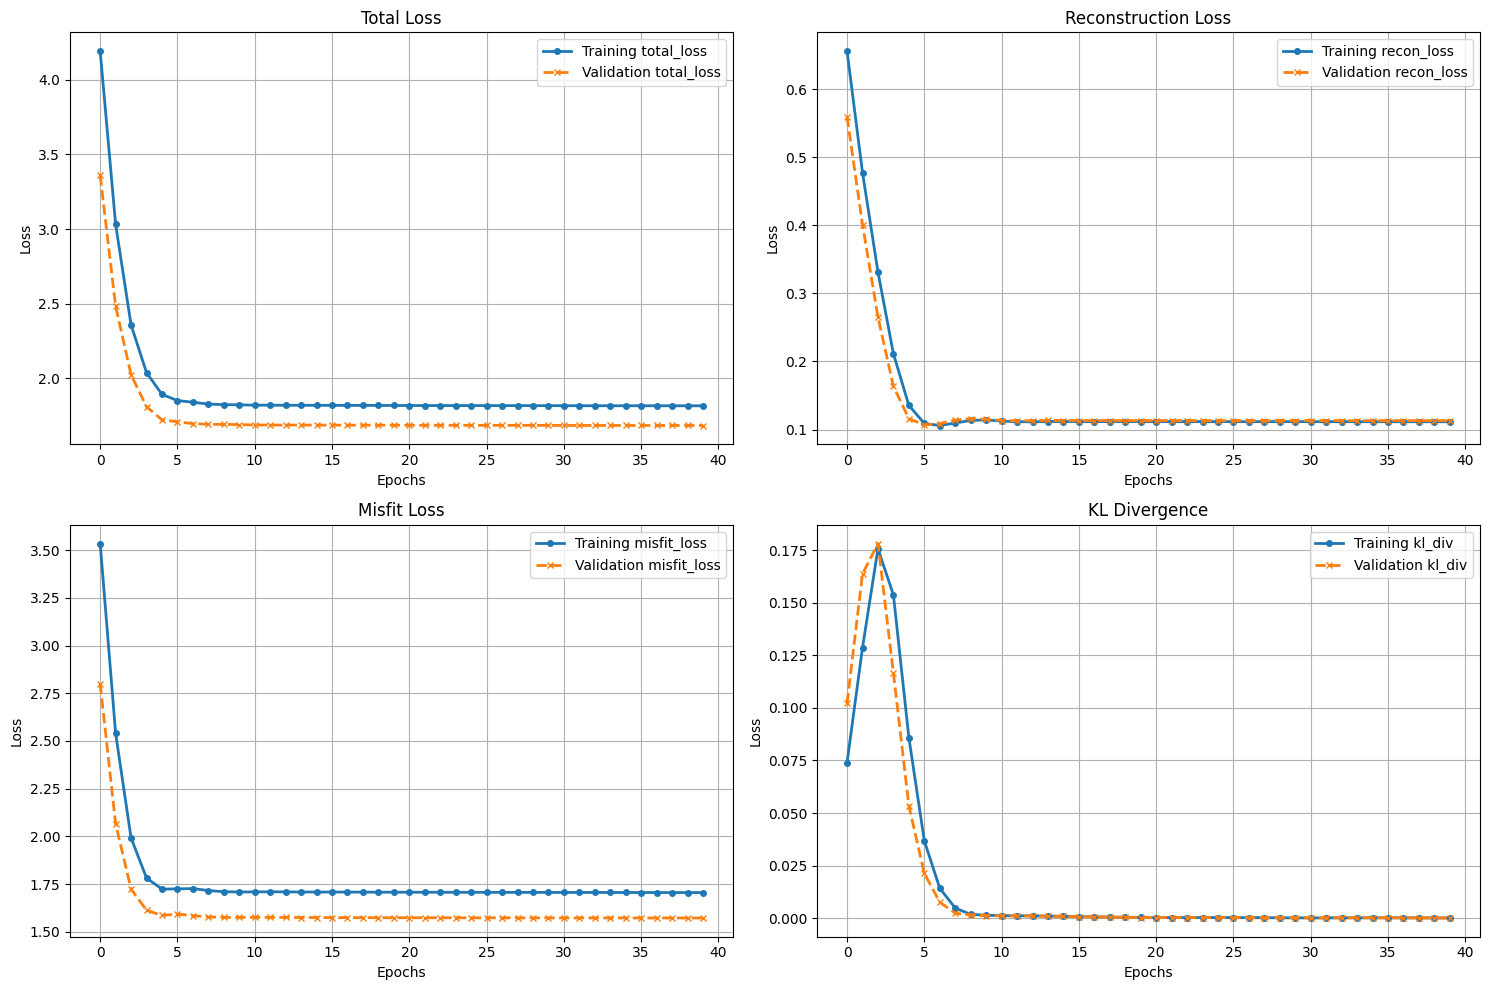

In [9]:
network.plot_loss()

# Inference

In [10]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


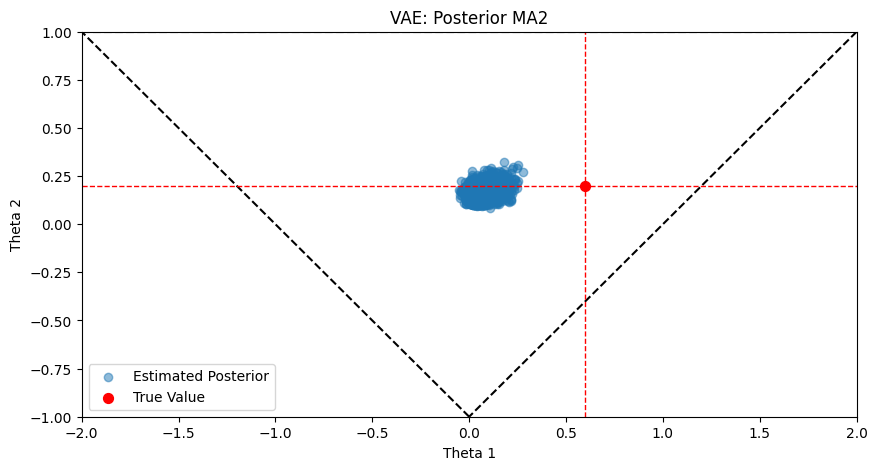

In [11]:
ma2.plot_posterior(post)

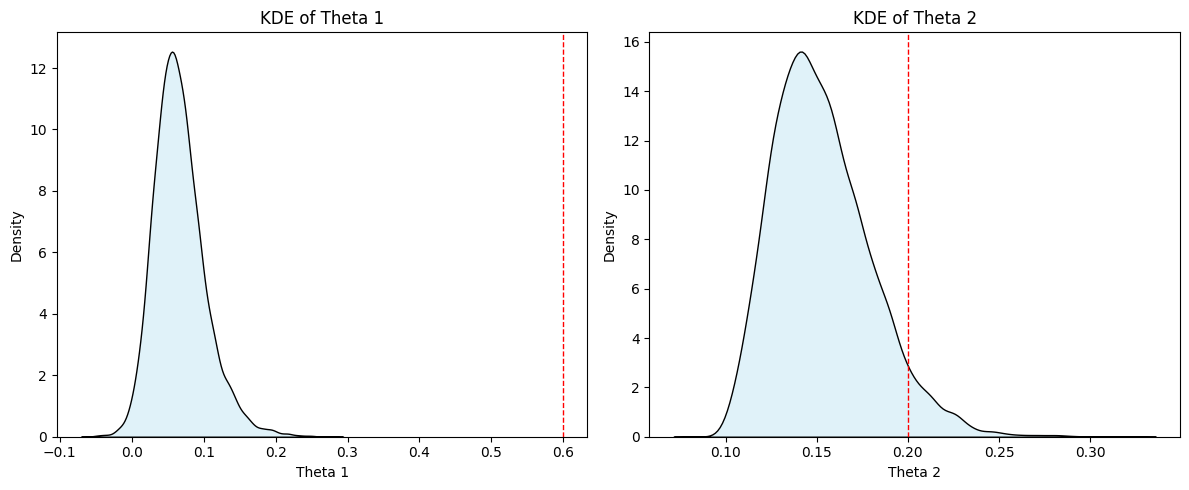

In [12]:
ma2.posterior_kde(post)

In [13]:

def simulator_batch(params, seed=42, n = 100, device=None):
    """
    Simulate data using the MA2 model for a batch of parameters.

    Parameters:
    - params (torch.Tensor): The batch of parameters for the MA2 model.
    - seed (int): Seed for random number generation to ensure reproducibility.
    - device (torch.device): The device to perform computations on.
    - n: Size of time series

    Returns:
    - torch.Tensor: Simulated data based on the MA2 model for each set of parameters in the batch.
    """
    # Set random seed for reproducibility
    torch.manual_seed(seed)

    # Ensure params has two dimensions [batch_size, param_dim]
    if params.ndimension() == 1:
        params = params.unsqueeze(0)
    
    # Set the device for computations
    device = device or torch.device("cpu")
    params = params.to(device)

    # Get batch size and sequence length
    batch_size, param_dim = params.size(0), params.size(1)
    

    # Generate random noise for all batches
    g = torch.randn(batch_size, n, device=device)
    gy = torch.randn(batch_size, n, device=device) * 0.3

    # Initialize x and y for all batches
    x = torch.zeros(batch_size, n, device=device)
    y = torch.zeros(batch_size, n, device=device)

    # Simulate the MA2 process in a vectorized form
    for t in range(n):
        x[:, t] += g[:, t]
        for p in range(1, min(t + 1, param_dim + 1)):  # Adjust the range to ensure correct parameter application
            x[:, t] += g[:, t - p] * params[:, p - 1] if t - p >= 0 else 0  # Apply parameter if index is valid
        y[:, t] = x[:, t] + gy[:, t]

    return y
def simulator_single(param, seed=42):
    """
    Simulate data using the MA2 model.

    Parameters:
    - param (torch.Tensor): The parameters for the MA2 model.
    - seed (int): Seed for random number generation to ensure reproducibility.

    Returns:
    - torch.Tensor: Simulated data based on the MA2 model.
    """
    torch.manual_seed(seed)
    n = 100
    m = len(param)
    g = torch.randn(n)
    gy = torch.randn(n) * 0.3
    y = torch.zeros(n)
    x = torch.zeros(n)
    for t in range(n):
        x[t] += g[t]
        for p in range(min(t, m)):
            x[t] += g[t - 1 - p] * param[p]
        y[t] = x[t] + gy[t]
    return y

param = torch.tensor([0.6,0.8], dtype = torch.float)
seed = 42

output_single = simulator_single(param, seed)
output_batch = simulator_batch(param.unsqueeze(0), seed)  # Add batch dimension

# Adjust for batch dimension in output_batch if necessary, e.g., output_batch.squeeze(0)
are_outputs_equal = torch.allclose(output_single, output_batch.squeeze(0), atol=1e-6)

print(f"Outputs are {'the same' if are_outputs_equal else 'different'}.")


Outputs are the same.


In [14]:
output_single

tensor([ 2.1448,  2.6708,  3.2179, -0.2169,  0.4450, -2.7233,  0.0629, -2.7174,
        -1.4209,  0.0157,  0.2110, -0.1967, -2.0560, -1.9670, -1.8294, -0.2940,
         1.4439,  1.9264,  0.9171,  0.1863, -1.0006,  0.9569,  0.8633,  3.2694,
         2.8155,  3.7183,  2.2056,  2.9292,  1.1229,  0.9566, -0.8419,  0.5724,
        -0.9892, -1.0773, -2.0737,  0.9176,  1.4830,  1.0208, -0.3819, -0.7815,
        -2.5218, -0.6838, -1.8871, -0.0888, -2.4305,  0.7783, -1.2745,  0.5279,
        -2.1082, -1.8160, -0.9955, -0.2821,  0.1789,  1.2264, -0.3182,  0.0641,
        -2.9601, -1.1677, -0.9318,  1.2743,  0.5511,  2.1344, -0.3033,  2.2109,
         1.0480,  2.3530,  3.5472,  2.3824,  2.6500,  0.8892, -1.3310,  0.2515,
         0.0578,  1.2761,  0.4444,  1.0923,  0.4163, -0.1732, -1.9915, -2.3880,
        -2.5573, -0.8254, -1.3916, -1.2547, -0.3920,  0.6458,  2.2697,  0.5499,
         0.0132,  0.4067,  0.1882,  0.4259,  0.2069,  0.8972,  0.6503,  0.4790,
        -1.0175, -0.6868, -0.2321,  0.70

In [15]:
output_batch

tensor([[ 2.1448,  2.6708,  3.2179, -0.2169,  0.4450, -2.7233,  0.0629, -2.7174,
         -1.4209,  0.0157,  0.2110, -0.1967, -2.0560, -1.9670, -1.8294, -0.2940,
          1.4439,  1.9264,  0.9171,  0.1863, -1.0006,  0.9569,  0.8633,  3.2694,
          2.8155,  3.7183,  2.2056,  2.9292,  1.1229,  0.9566, -0.8419,  0.5724,
         -0.9892, -1.0773, -2.0737,  0.9176,  1.4830,  1.0208, -0.3819, -0.7815,
         -2.5218, -0.6838, -1.8871, -0.0888, -2.4305,  0.7783, -1.2745,  0.5279,
         -2.1082, -1.8160, -0.9955, -0.2821,  0.1789,  1.2264, -0.3182,  0.0641,
         -2.9601, -1.1677, -0.9318,  1.2743,  0.5511,  2.1344, -0.3033,  2.2109,
          1.0480,  2.3530,  3.5472,  2.3824,  2.6500,  0.8892, -1.3310,  0.2515,
          0.0578,  1.2761,  0.4444,  1.0923,  0.4163, -0.1732, -1.9915, -2.3880,
         -2.5573, -0.8254, -1.3916, -1.2547, -0.3920,  0.6458,  2.2697,  0.5499,
          0.0132,  0.4067,  0.1882,  0.4259,  0.2069,  0.8972,  0.6503,  0.4790,
         -1.0175, -0.6868, -